# Pouso de meteoritos no planeta Terra 

Este notebook traz o relatório final da pesquisa da disciplina de Introdução à Ciência de Dados, orientada pelo Prof. Dr. Yuri Malheiros, no semestre 2022.2.
As autoras da pesquisa são:
- [Iara Araújo](https://github.com/araujo44/)
- Beatriz Barreto 
- Paloma Duarte

## Introdução

### Motivação e objetivos)
   O fluxo de materiais espaciais no planeta Terra atrai a curiosidade dos seres humanos desde as suas primeiras sociedades de coletores-caçadores. Na atualidade, estes eventos são registrados para estudos e, quando possível, seus resquícios materiais são coletados para análises. Em particular, os fragmentos rochosos vindos do espaço podem trazer informações valiosas para os seres humanos, como a composição de planetas, novas estruturas químicas e até indícios sobre a origem da vida no planeta (MOURÃO, 1982).</br>
    Esta pesquisa propõe uma análise de rochas espaciais que atingem a atmosfera terrestre. Tanto as condições de seu percurso luminoso (conhecido por meteoro), quanto o pouso na superfície do planeta (chamadas de meteoritos).

 Com a observação de eventos espaciais envolvendo objetos em alta velocidade, nossa análise busca compreender os fatores que permeiam a relação terra-espaço, especificamente na queda de meteoros no planeta terra. Com isso, buscamos interpretar os dados(localização, massa, velocidade, energia de impacto, etc) para estabelecer correlações e identificar padrões.
 
   O objetivo da pesquisa é conhecer um pouco sobre as características de meteoros e meteoritos a partir da coleta, limpeza e análise de seus registros. Busca-se verificar a magnitude dos fenômenos, como a energia emitida por um meteoro e algumas estatísticas que permitam caracterizar os eventos, tais como média de massa de um meteorito e principais locais de impacto. Também são trazidas visualizações gráficas detalhando a quantidade de meteoritos por ano e correlações entre as suas variáveis observadas. Algumas informações sobre registros mais conhecidos são abordadas ao longo da pesquisa. 

## Dados Utilizados

### Dataset meteorite_landings
- Dados coletados pela [Meteorical Society](https://meteoritical.org/), incluindo localizações, massas,composições e ano de queda 
para mais de 45.000 meteoritos que caíram no planeta terra.
- Variáveis desse dataset:
    - **name**: nome do meteorito(geralmente relacionado com a localização onde atingiu a terra).
    - **id** : identificador único para o meteorito no dataset.
    - **nametype**: classificação do meteorito em **relict** ou **valid**
    - **mass** : a massa do meteorito dada em gramas.
    - **fell**: classificação do meteorito em:
        - _Fall_: se foi identificado durante sua queda.
        - _Fell_: se foi identificado após sua queda.
    - **year**: ano em que o meteorito foi identificado.
    - **reclat**: latitude da posição em que o meteoro foi encontrado.
    - **reclong**: longitude da posição em que o meteoro foi encontrado.
    - **GeoLocation**: junção da latitude e da longitude em uma variável, separadas por vírgula.    
- Observações adicionais
    - as variáveis 'reclat' e 'reclong' são "valores recomendados", isto é levemente alterados do valor inicialmente dado, isso se deve a uma reclassificação do meteorito ou alteração dos dados originais de sua coleta.
    - alguns dados estão incorretos ou com difícil visualização, por isso faremos a limpeza na fase de pré processamento.
---
### Dataset meteorite_landings_on_earth
- Dados coletados e disponibilizados pela [NASA](https://data.nasa.gov/), incluindo registros de 45.000 meteoritos com dados de detalhamento extras, como nome do país/oceano encontrado.
- Variáveis do dataset:
    - **id** : identificador único para o meteorito dentro do dataset.
    - **meteorite_name**: nome do meteorito.
    - **nametype**: classificação do meteorito em **relict** ou **valid**
    - **recclass**: é o processo de passagem de uma classe, classificação ou categoria para outra.
    - **fall**: classificação do meteorito em:
        - _Fall_: se foi identificado durante sua queda.
        - _Fell_: se foi identificado após sua queda.
    - **year**: ano em que o meteorito foi identificado.
    - **mass** : a massa do meteorito dada em gramas.
    - **location**: nome do país ou oceano em que o meteorito foi encontrado.
    - **location_code**: código de identificação do país ou oceano em que o meteorito foi encontrado.
    - **location_type**: tipo de localização do local em que o meteoro foi encontrado, classificado em:
        - _Land_: se foi identificado na terra.
        - _Ocean_: se foi identificado no oceano.
        - _Unknown_: se foi identificado em um local que pode ter mudado de classificação de terra para oceano, ou visse-versa, desde sua queda.
    - **distance**: deslocamento do meteorito desde sua queda.
    - **latitude**: latitude da posição em que o meteorito foi encontrado.
    - **longitude**: longitude da posição em que o meteorito foi encontrado.
    - **lat_lng**: junção da latitude e da longitude em uma variável, separadas por vírgula.
---
### Dataset para exploração de Meteoros
   Para análise de meteoros, selecionou-se o dataset 'fireball_and_bolides_reports.csv', importado do site dados públicos da Nasa - [data.gov](https://catalog.data.gov/dataset/fireball-and-bolide-reports) e contava com 92 registros. Posteriormente, links desse site levaram à obtenção do dataset 'cneos_fireball_data.csv'. Este último foi retirado da página do [Center for Near Earth Object Studies](https://cneos.jpl.nasa.gov/fireballs/), uma seção do órgão governamental americano voltada aos asteroides e cometas na órbita terrestre. O dataset conta com 953 registros de meteoros no último acesso (23/04/2023), dos quais fazem parte os dados do dataset anterior. Por isso, optou-se por prosseguir com o segundo dataset. </br>
    A legenda de suas colunas conforme descrita na página é:
- Peak Brightness Date/Time (UT): a data e o tempo em UT(do inglês, Universal Time), do pico de luminosidade do evento.
- Latitude (deg.): Latitude geodésica em graus norte (N) ou sul (S) do equador para este evento.
- Longitude (deg.): Longitude geodésica em graus leste (E) ou oeste (W) do meridiano principal para este evento.
- Altitude (km): Altitude em quilômetros (km) acima do geóide de referência para este evento.
- Velocity (km/s): A magnitude da velocidade pré-impacto do meteoro em quilômetros por segundo (km/s).
- Velocity Components (km/s): A magnitude da velocidade pré-impacto do meteoro em um referencial geocêntrico fixo na Terra definido da seguinte forma: o eixo z é direcionado ao longo do eixo de rotação da Terra em direção ao polo norte celeste, o eixo x está no plano equatorial da Terra, direcionado em direção ao meridiano principal, e o eixo y completa o sistema de coordenadas da mão direita.
- Total Radiated Energy (J): A energia irradiada total aproximada na atmosfera em Joules (uma unidade de energia dada em quilogramas vezes velocidade ao quadrado, ou $kg × (m/s)^2$].
- **Calculated Total Impact Energy (kt)**: A energia de impacto do evento em quilotons de TNT (kt) calculada a partir de uma expressão empírica relacionando energia irradiada e de impacto.

### Dataset sobre Meteoritos no Brasil
   Para uma exploração mais aprofundada no meteoritos com pouso em solo brasileiro, foram coletados registros da base de dados do [The Meteoritical Society](https://www.lpi.usra.edu/meteor/metbull.php), uma sociedade internacional voltada para ciência meteorítica e planetária. A página não disponibiliza os dados em formato de tabela, então foi feito um web scraping a partir da categoria desejada (o país), em todos os boletins do database. Foram obtidos 100 registros de meteoritos brasileiros. </br>
   As colunas do dataset e seus respectivos significados são, em sequência:
- **Name**: nomes oficiais (reconhecidos pelo Comitê de Nomenclatura de Meteoritos) e não oficiais. Os meteoritos com nomes oficiais contêm a palavra "Oficial" na coluna de status.
- **Status**: O status do nome do meteorito, onde: "Oficial" indica um nome formalmente reconhecido; "Duvidoso" geralmente indica que há dúvidas sobre a existência de meteoritos reais recuperados; "Pseudo" indica que o nome se refere a um objeto que comprovadamente NÃO é um meteorito, e "Provisório" indica que o nome foi atribuído pelo Comitê de Nomenclatura, mas a aprovação formal não foi concedida (nomes provisórios não devem ser usado em publicações).
- Fall: Os meteoritos classificados antes de 2015 têm uma das duas entradas na coluna Fall:
    - "Fall" (símbolo Y; o meteorito foi registrado no MetBull ou em catálogos mais antigos como uma queda)
    - "Find" (a coluna ficará em branco, indicando que o meteorito foi registrado como um achado)
    A partir de 2015 (MetBull 104), existem 5 categorias de quedas e achados:
    - "Queda confirmada" (símbolo Yc)
    - "Provável queda" (símbolo Yp)
    - "Encontrar, possível queda" (símbolo Np)
    - "Encontrar, queda duvidosa" (símbolo Nd)
    - "Encontrar" (em branco, assim como os achados mais antigos)
- Year: o ano do achado ou queda. Para meteoritos de procedência desconhecida, este campo também pode conter o ano da compra. Se forem mostrados dois anos, isso indica desacordo entre as duas fontes utilizadas para a compilação.
- Place: os países são baseados principalmente no país fornecido para cada meteorito no boletim que publicou o registro.
- Type: mostra a classificação do meteorito. Se o meteorito foi publicado no Catálogo de Meteoritos e no MetBase (ver colunas NHMCat e MetBase), ambas as classificações aparecerão se não concordarem. 
- Mass: o peso total conhecido do meteorito. Podem estar arredondadas.
- MetBull: número do Boletim Meteorítico em que o nome foi publicado.
As colunas de "Google Earth" e "Notes" foram descartadas por conter dados fora do escopo da pesquisa. As demais variáveis utilizadas e sua descrição detalhada são encontradas no formato de display "Normal table".

In [107]:
import pandas as pd
import numpy as np
#import math
from math import log, e, sqrt
import statistics
import seaborn as sns
from scipy.stats import linregress
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

In [ ]:
# durante a análise foi usada a numeração para se referir aos datasets respectivamente:

In [40]:
#lendo os datasets
df1 = pd.read_csv('datasets/meteorite_landings.csv', on_bad_lines='warn') 
df2 = pd.read_csv('datasets/meteorite_landings_on_earth.csv', on_bad_lines='warn')   
df3 = pd.read_csv('datasets/cneos_fireball_data.csv', on_bad_lines='warn')
df4 = pd.read_csv('datasets/meteoritos_brasil.csv')

## Pré-processamento dos dados

### Dataset meteorite_landings

#### Corrigindo dados na variável 'year'

- Aqui faremos uma verificação do ano em que o meteorito foi descoberto, pois existem algumas incoerências. 
  
  Faremos essa verificação utilizando como base o site [The Meteoritical Society](https://www.lpi.usra.edu/meteor/metbull.php).
  

In [3]:

years_bug = [i for i in df1['year'] if i >= 2016 or i <= 860 ] # pega os anos incoerentes

index_bug = [i for i in df1.index if df1.loc[i, 'year'] in years_bug] # pega os índices dos elementos problemáticos 

name_years_bug = [df1['name'].loc[i] for i in df1.index if df1.loc[i, 'year'] in years_bug] # pega o nome dos elementos para a verificação no site

print(name_years_bug)
index_bug


['Nogata', 'Havana', 'Northwest Africa 7701', 'Ur', 'Wietrzno-Bobrka']


[703, 16356, 30679, 38188, 38301]

- Agora vamos corrigir as informações no dataframe:

In [4]:
years_bug = [i for i in df1['year'] if i >= 2016 or i <= 860 ] # pega os anos incoerentes

index_bug = [i for i in df1.index if df1.loc[i, 'year'] in years_bug] # pega os índices dos elementos problemáticos 



df1 = df1.drop(index_bug) #removendo os rows em que os anos são problemáticos


#### Corrigindo dados das variáveis 'reclat' e 'reclong'

In [5]:
df1['reclong'] = df1['reclong'].map(lambda x : 61.074319 if (x > 180 or x < - 180) else x) #correção de incoerências das colunas 'reclat' e 'reclong'
df1['reclat'] = df1['reclat'].map(lambda x : -39.122580 if (x == 0) else x)

#### Criando escala logarítmica para variáveis 'mass' e 'year'

In [6]:
df1['log mass'] = np.log10(df1['mass']) #criando a escala em log para diminuir a distorção
                                        #ele deu esse erro, mas produziu mesmo assim

c:\Users\biabc\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [9]:
year_copy = (df1[df1['year'] > 0]).copy()

df1['log year'] = np.log10(year_copy['year'])


### Dataset dos Fireballs
No dataset sobre Fireballs, foi verificado distorções em relação aos valores da variável Energia Irradiada Total e Energia de Impacto Total. Para melhor visualizar esses valores em gráficos, adicionaremos duas novas colunas ao dataset partindo de uma função logarítmica.

In [89]:
# Acrescentando coluna com log_{10} do'Total Radiated Energy'
#radiated_energy_log = np.log10(df3['Total Radiated Energy (J)'])  # criando array com funcao log
#df3['Total Radiated Energy (J) - log[10]'] = radiated_energy_log  # inserindo como coluna do dataset

# Acrescentando coluna com log natural do'Total Radiated Energy'
radiated_energy_log = np.log(df3['Total Radiated Energy (J)'])  # criando array com funcao log
df3['Total Radiated Energy (J) - log'] = radiated_energy_log  # inserindo como coluna do dataset


# Acrescentando coluna com log natural do 'Total Impact Energy'
impact_energy_log = np.log(df3['Calculated Total Impact Energy (kt)'])  # criando array com funcao log
df3['Calculated Total Impact Energy (kt) - log'] = impact_energy_log # inserindo como coluna do dataset

df3.head(3)

,Peak Brightness Date/Time (UT),Latitude (deg.),Longitude (deg.),Altitude (km),Velocity (km/s),vx,vy,vz,Total Radiated Energy (J),Calculated Total Impact Energy (kt),Total Radiated Energy (J) - log,Calculated Total Impact Energy (kt) - log
0,2023-04-15 08:22:01,20.1S,36.0E,41.4,17.2,1.6,-14.7,8.8,3.097000e+12,6.300,28.761455,1.840550
1,2023-04-06 14:47:39,57.4N,109.9E,31.2,22.1,8.6,3.6,-20.0,7.200000e+10,0.230,24.999932,-1.469676
2,2023-04-01 00:02:03,16.8S,76.0E,61.8,46.4,21.4,-40.6,7.1,2.400000e+10,0.086,23.901320,-2.453408


In [126]:
# verificando as informações da coluna Dia e Hora
print(df3['Peak Brightness Date/Time (UT)'].min())
print(df3['Peak Brightness Date/Time (UT)'].max())

1988-04-15 03:03:10
2023-04-15 08:22:01


Os registros desse dataset vão de abril de 1988 até  abril de 2023 (35 anos).

### Dataset sobre Meteoritos no Brasil

No dataset 'meteoritos_brasil.csv' as colunas iniciais com informações de ordem e url do web scraping. Não são relevantes à análisa e foram removidas.

In [41]:
df4 = pd.read_csv('datasets/meteoritos_brasil.csv')
df4.head(3) # colunas 0 e 1 com informações não relevantes

,web-scraper-order,web-scraper-start-url,Name,Status,Fall,Year,Place,Type,Mass,MetBull
0,1685536964-1,https://www.lpi.usra.edu/meteor/metbull.php?se...,Angra dos Reis (stone),Official,Y,1869,"Rio de Janeiro, Brazil",Angrite,1500 g,NaN
1,1685536964-2,https://www.lpi.usra.edu/meteor/metbull.php?se...,Araguainha **,Crater,NaN,254.7 ± 2.5 Ma,"Mato Grosso, Brazil",Impact Crater,NaN,NaN
2,1685536964-3,https://www.lpi.usra.edu/meteor/metbull.php?se...,Arraias **,Official,NaN,2015,"Tocantins, Brazil","Iron, IIAB",25 kg,108.0


In [42]:
df4 = df4.drop(columns=['web-scraper-order','web-scraper-start-url'])

#### Coluna Mass

- A coluna Mass apresenta dados não homogeneizados, as unidades encontradas são g, kg e t. Também apresenta registros de massa desconhecida (algumas são crateras)

In [43]:
def converter_em_gramas(massa):
    "recebe uma massa em string e converte para um float (em gramas)"
    if massa != massa:  # é verdadeiro para NaN, caso das crateras
        return massa
    valor, unidade = massa.split(' ')
    valor = float(valor) # casting da magnitude
    if unidade == "g":    
        return valor
    if unidade == "kg": # 1kg = 1000g
        return valor * 1000
    if unidade == "t": # 1t = 1000000g
        return valor * 1000000

In [44]:
# Homogeneizando coluna da Mass (os valores devem ser em gramas ou nan)
mass_g = [converter_em_gramas(m) for m in df4['Mass']]
df4['Mass'] = mass_g

In [45]:
# criando nova coluna para Mass, utilizando função logarítmica
log_mass = [log(m) for m in df['Mass']]
df4['log_Mass'] = log_mass # adicionando coluna ao dataset
df4.head(3)

,Name,Status,Fall,Year,Place,Type,Mass,MetBull,log_Mass
0,Angra dos Reis (stone),Official,Y,1869,"Rio de Janeiro, Brazil",Angrite,1500.0,NaN,7.313220
1,Araguainha **,Crater,NaN,254.7 ± 2.5 Ma,"Mato Grosso, Brazil",Impact Crater,NaN,NaN,NaN
2,Arraias **,Official,NaN,2015,"Tocantins, Brazil","Iron, IIAB",25000.0,108.0,10.126631


## Exploração inicial 

### Dataset meteorite_landings

#### Medidas de centralidade

- Medianas

In [8]:
print((df1.sort_values(by='year', ascending=False).dropna()['year']).median()) # mediana de 'year'

print((df1.sort_values(by='mass', ascending=False).dropna()['mass']).median()) # mediana de 'mass'

print((df1.sort_values(by='reclat', ascending=False).dropna()['reclat']).median()) # mediana de 'reclat'

print((df1.sort_values(by='reclong', ascending=False).dropna()['reclong']).median()) # mediana de 'reclong'


1996.0
29.08
-71.5
35.66667


- Médias


In [9]:
df1.mean(numeric_only='True')

id         26889.736628
mass       13278.932641
year        1991.851331
reclat       -45.690505
reclong       61.071807
dtype: float64

- Modas

In [10]:
df1.mode(dropna='True')[['mass', 'year', 'fall', 'recclass']].head(1)

,mass,year,fall,recclass
0,1.3,2003.0,Found,L6


#### Medidas de dispersão

- Desvio padrão

In [9]:
df1.std(numeric_only=True).dropna() 

id          16860.791462
mass       575007.788451
year           24.478620
reclat         43.021263
reclong        80.633287
dtype: float64

- Variâncias

In [14]:
df1.var(numeric_only=True).dropna()

id         2.842863e+08
mass       3.306340e+11
year       5.992028e+02
reclat     1.850829e+03
reclong    6.501727e+03
dtype: float64

#### Alguns boxplots e visualizações

<AxesSubplot:xlabel='log mass'>

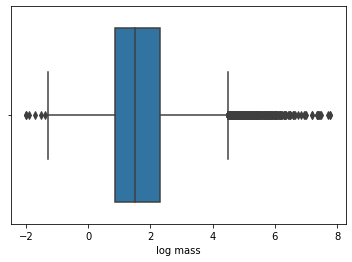

In [25]:
sns.boxplot(data=df1, x="log mass") # boxplot da variável 'mass' em escala logarítmica

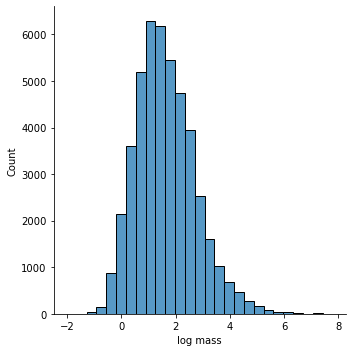

In [27]:
sns.displot(data=df1,x='log mass', bins=27) # Histograma da variável 'mass' em escala logarítmica

<AxesSubplot:ylabel='Frequency'>

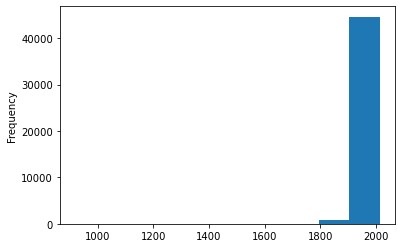

In [18]:
df1['year'].plot.hist() # Histograma da variável year

<AxesSubplot:xlabel='log year'>

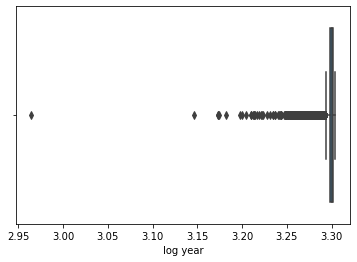

In [20]:
year_copy = (df1[df1['year'] > 0]).copy()

df1['log year'] = np.log10(year_copy['year'])

sns.boxplot(data=df1, x='log year') #utilizando a escala em logarítmica

# Boxplot variável year em escala logarítmica

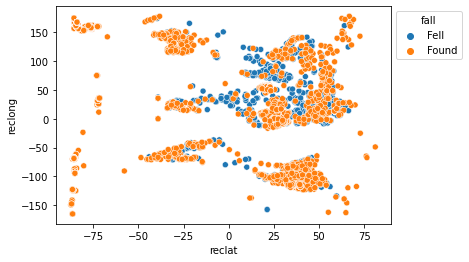

In [30]:
ax = sns.scatterplot(data=df1, x='reclat',y='reclong', hue='fall') # Gráfico exibindo as localizações onde meteoritos caíram e se foram ou não vistos caindo.
sns.move_legend(ax, "upper left", bbox_to_anchor=(1,1))

- Aqui podemos apontar que a maioria dos meteoritos não foram observados durante sua queda, sendo descobertos apenas após encontrarem o solo.

<AxesSubplot:>

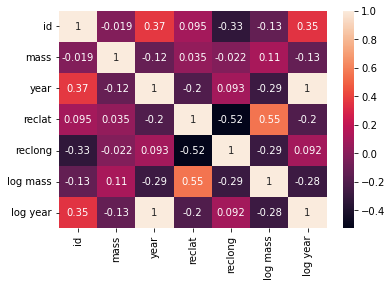

In [36]:
sns.heatmap(df1.corr(), annot=True) #representação da correlação entre os elementos do df1

<AxesSubplot:xlabel='year', ylabel='mass'>

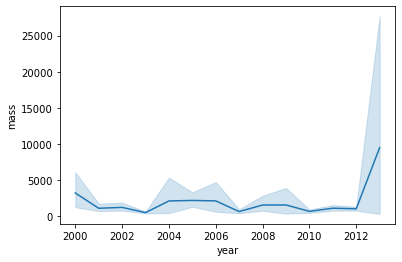

In [39]:
year_cut = df1[df1['year'] >=2000]

sns.lineplot(data=year_cut, x='year', y='mass') #gráfico da variação do tamanho da massa entre os anos 2000

- Notamos aqui um crescimento na massa a partir de anos por volta de 2012

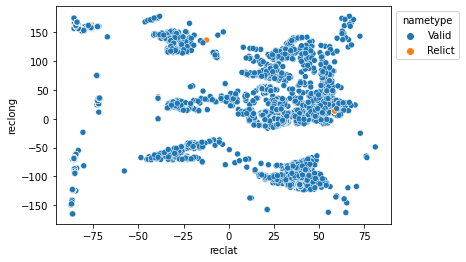

In [42]:
ax = sns.scatterplot(data=df1, x='reclat', y = 'reclong',hue='nametype') # Gráfico exibindo a quantidade de meteoritos e relictos()
sns.move_legend(ax, "upper left", bbox_to_anchor=(1,1))

<AxesSubplot:xlabel='year', ylabel='year'>

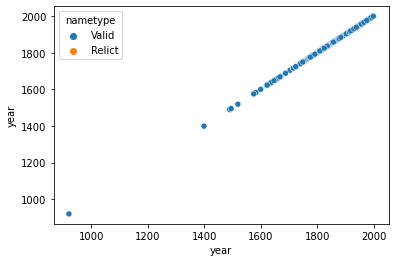

In [44]:
year_cut = df1[df1['year'] < 2000 ]
sns.scatterplot(data=year_cut, x='year',y='year', hue='nametype')

- Com base nos gráficos acima, podemos deduzir que existem pouquíssimos relictos registrados, isto é, objetos altamente alterados que provavelmente possuem origem de meteorito, desgastados pelo clima do planeta terra.

### Exploração do dataset Fireballs

<Axes: xlabel='Total Radiated Energy (J)', ylabel='Count'>

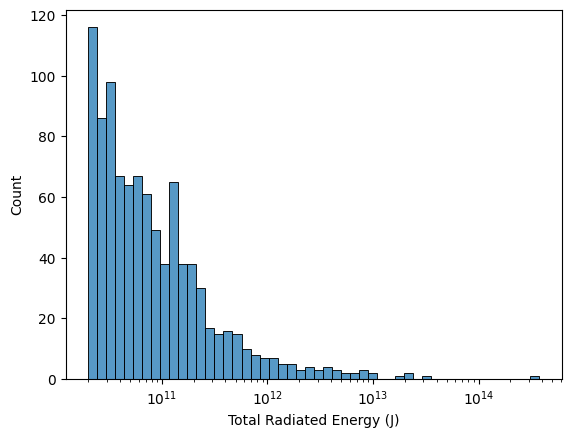

In [72]:
sns.histplot(data=df3,x='Total Radiated Energy (J)', log_scale=True, bins=50)

Este histograma representa a frequência do pico da Energia Óptica Irradiada pelos meteoros registrados.  

## Perguntas

### Quais os maiores meteoros a atingirem a Terra?

In [12]:
ord_massa = df1[['name','mass']].sort_values(by='mass',ascending=False).dropna() #Os meteoritos com maiores massas registradas
ord_massa

,name,mass
16383,Hoba,60000000.0
5336,Cape York,58200000.0
5329,Campo del Cielo,50000000.0
5333,Canyon Diablo,30000000.0
3433,Armanty,28000000.0
...,...,...
31065,Österplana 053,0.0
31066,Österplana 054,0.0
31067,Österplana 055,0.0
31068,Österplana 056,0.0


- Os 5 meteoritos com maior massa em ordem descrescente são: Hoba com 60000000 gramas, Cape York com 58200000 gramas, Campo del Cielo 50000000 gramas, Canyon Diablo com 30000000 gramas e Armanty com 28000000 gramas. 

### Qual a média anual de meteoritos a atingirem o planeta?

In [13]:
cont_years = df1[['year']].value_counts().sort_values(ascending=False) #contando os anos existentes para o cálculo da média.

cont_years

year  
2003.0    3323
1979.0    3046
1998.0    2697
2006.0    2456
1988.0    2296
          ... 
1628.0       1
1741.0       1
1623.0       1
1575.0       1
920.0        1
Length: 263, dtype: int64

In [14]:
#263 anos existentes e 45582 meteoritos registrados.

met_por_ano = 45582/263

met_por_ano

# a média anual de meteoritos por ano é de 173. Podemos analisar que a média é afetada por anos onde a concentração de meteoritos foi maior, pois "173 meteoritos p/ano" 
# não expressa nitidamente a realidade, uma vez que existem anos onde apenas 1 meteorito foi registrado.

173.31558935361215

- A média anual de meteoritos é de 173. Podemos analisar que a média é afetada por anos com a concentração de meteoritos maior, pois "173 meteoritos p/ano"  não expressa nitidamente a realidade, uma vez que existem anos onde apenas 1 meteorito foi registrado.

### Há alguma relação entre a massa e o ano em que o meteorito foi encontrado?

c:\Users\biabc\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


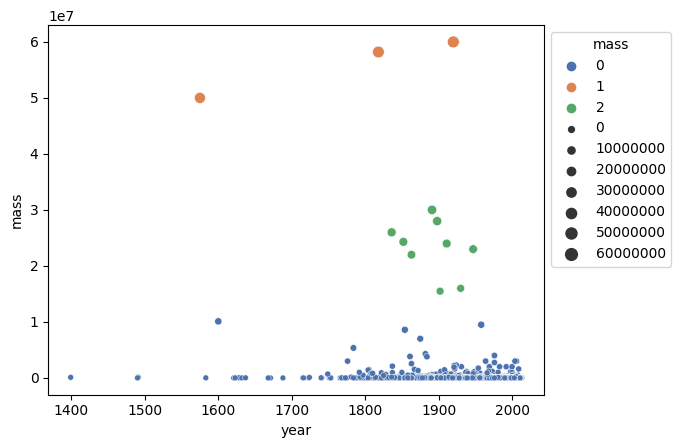

In [10]:
# Vamos realizar o agrupamento por k-means, utilizando k = 3 (valor escolhido com base no "elbow method").

df_group = df1[['mass', 'year']].dropna()

kmeans3 = KMeans(n_clusters=3)

kmeans3.fit(df_group)

plot3 = sns.scatterplot(data=df_group, x= 'year',y = 'mass', hue=kmeans3.labels_, palette="deep", size='mass')

sns.move_legend(plot3, "upper left", bbox_to_anchor=(1,1))

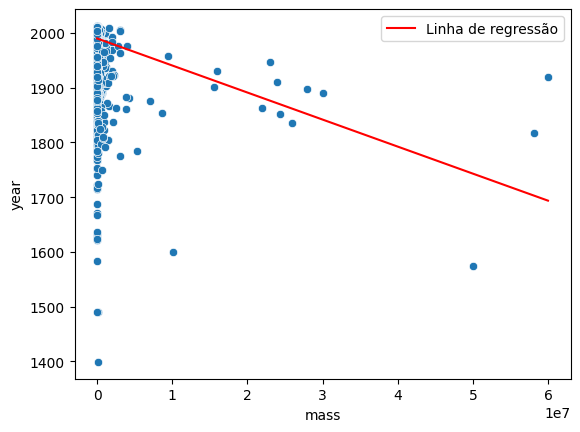

In [46]:
# Aqui, com a tentativa de representar usando regressão linear, notamos que os valores não são lineares.
df1_noNa = df1.dropna()
reg_lin1 = linregress(df1_noNa['mass'], df1_noNa['year'])

def f(x, regre):
    return x*regre.slope + regre.intercept

plotreg_lin1 = sns.scatterplot(data=df1_noNa, x='mass', y='year')
plt.plot((0,60000000), (f(0, reg_lin1), f(60000000,reg_lin1)), c='red', label='Linha de regressão')
plt.legend()
plt.show()

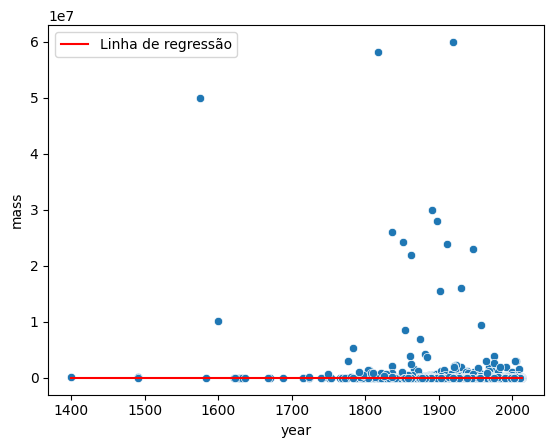

In [49]:
# Agora trocando os eixos.
reg_lin2 = linregress(df1_noNa['mass'], df1_noNa['year'])

plotreg_lin2 = sns.scatterplot(data=df1_noNa, x= 'year',y = 'mass')
plt.plot((1399,2013), (f(1399, reg_lin2), f(2013, reg_lin2)), c='red', label='Linha de regressão')
plt.legend()
plt.show()


- O que se pode tirar dos gráficos acima é que os valores não seguem um padrão, são puramente aleatórios. Pode ser que existam outros fatores como clima que afetem o tamanho dos meteoritos, mas não conseguimos explorar melhor isso com as informações que temos.

### Quais áreas do planeta são mais atingidas por meteoros?


### Entre os meteoros registrados, quais penetraram a atmosfera terrestre com maior energia de impacto?
No dataset 3, temos a coluna "Calculated Total Impact Energy", que indica a energia aproximada de impacto do evento em kilotons (kt). Os valores do dataset serão rankeados com base nessa coluna.

In [49]:
top10_impact = df3.sort_values('Calculated Total Impact Energy (kt)', ascending=False)
top10_impact.iloc[0:10]

,Peak Brightness Date/Time (UT),Latitude (deg.),Longitude (deg.),Altitude (km),Velocity (km/s),vx,vy,vz,Total Radiated Energy (J),Calculated Total Impact Energy (kt)
369,2013-02-15 03:20:33,54.8N,61.1E,23.3,18.6,12.8,-13.3,-2.4,3.750000e+14,440.0
171,2018-12-18 23:48:20,56.9N,172.4E,26.0,13.6,6.3,-3.0,-31.2,3.130000e+13,49.0
441,2010-12-25 23:24:00,38.0N,158.0E,26.0,18.1,18.0,-2.0,-4.0,2.000000e+13,33.0
487,2009-10-08 02:57:00,4.2S,120.6E,19.1,19.2,14.0,-16.0,-6.0,2.000000e+13,33.0
947,1994-02-01 22:38:09,2.7N,164.1E,NaN,NaN,NaN,NaN,NaN,1.820000e+13,30.0
480,2009-11-21 20:53:00,22.0S,29.2E,38.0,32.1,3.0,-17.0,27.0,1.000000e+13,18.0
660,2004-10-07 13:14:43,27.3S,71.5E,35.0,19.2,-15.3,1.0,11.6,1.040000e+13,18.0
571,2006-12-09 06:31:12,26.2N,26.0E,26.5,15.9,4.9,-15.0,1.6,7.410000e+12,14.0
461,2010-07-06 23:54:43,34.1S,174.5W,26.0,15.7,12.1,10.0,0.2,7.560000e+12,14.0
952,1988-04-15 03:03:10,4.1S,124.3E,NaN,NaN,NaN,NaN,NaN,7.580000e+12,14.0


Um dado destacável no quadro é o evento de maior energia de impacto registrado, com 440 kilotons (equivale à força da energia liberada por 1000 toneladas de explosivos de TNT). Pela datação, foram encontrados os registros em vídeo e notícias:
* Este evento atingiu a Rússia em fevereiro de 2013. Estima-se o peso de cerca de 13t. A rocha se desintegrou antes de atingir o solo, causando danos em edifícios e deixando quase mil feridos. Fonte: [Meteoro de Chelyabinsk (G1)](http://glo.bo/HKfp26). Registros em vídeo do meteoro podem ser encontrados em: [Meteor Hits Russia Feb 15, 2013](https://youtu.be/dpmXyJrs7iU)

### Quais as velocidades mais frequentes dos meteoros?
Ainda no dataset 3, interessa encontrar a velocidade com que a maioria dos meteoros entra na atmosfera.

<Axes: >

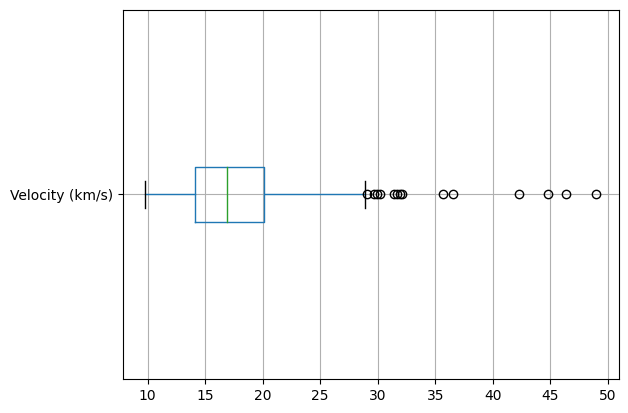

In [68]:
df3.boxplot(column=['Velocity (km/s)'], vert=False)

Pelo boxplot, percebemos que as discrepândias na velocidade dos eventos pelo grande número de outliers. Para visualizarmos de modo mais preciso os demais valores,será utilizada a uma contagem da variável "Velocity"

<Axes: xlabel='Velocity (km/s)', ylabel='Count'>

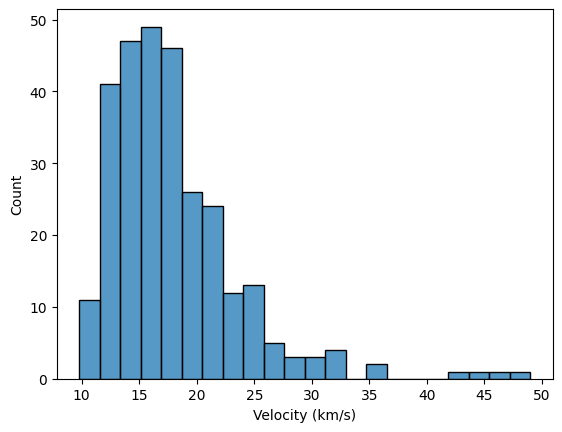

In [73]:
sns.histplot(data=df3,x='Velocity (km/s)')

- Pelo histograma, percebe-se que a maioria dos meteoros apresenta velocidade entre 10 e 20km/s, com ao menos 10 eventos registrados para velocidades dentro do intervalo.  

### Há alguma relação entre a velocidade dos meteoros que entram na atmosfera terrestre e sua energia de impacto?
Usaremos o método de correlação de Pearson para verificar a relação entre as duas variáveis.

In [77]:
df3['Velocity (km/s)'].corr(df3['Calculated Total Impact Energy (kt)'])

0.002862478431024519

Isto indica uma correlação muito fraca. A visualização da correlaçãopode ser vista através da dispersão das variáveis:

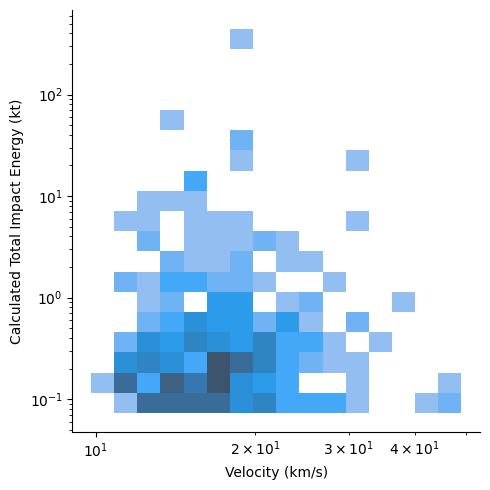

In [95]:
sns.displot(data=df3,x='Velocity (km/s)', y='Calculated Total Impact Energy (kt)', log_scale=True)

<Axes: xlabel='Velocity (km/s)', ylabel='Calculated Total Impact Energy (kt) - log'>

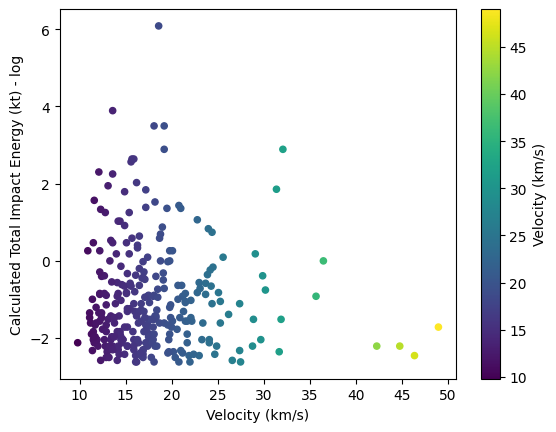

In [93]:
# visualizando através do matplot
# não visualiza a densidade das regiões no gráfico
# melhora a identificação das velocidades
df3.plot.scatter(x = 'Velocity (km/s)',
                y = 'Calculated Total Impact Energy (kt) - log',
                c = 'Velocity (km/s)',
                colormap='viridis')

Através dos plots e do coeficiente de correlação, não é verificada uma relação entre a Velocidade e Energia de Impacto. Por isso, não será buscada uma regressão linear para essas variáveis.  

### Há alguma relação entre o brilho dos meteoros que entram na atmosfera terrestre e sua energia de impacto?

 Pela definição fornecida na fonte do dataset, a variável "Calculated Total Impact Energy (kt" foi removida porque as variáveis já estão relacionadas por uma equação. Mais informações em: Brown et al., The flux of small near-Earth objects colliding with the Earth. Nature, vol. 420, 21 Nov. 2002, pp. 294-296. A energia de impacto é encontrada a partir de uma função exponencial cuja única variável é a energia irradiada (convertida de Joules para kilotons).

In [133]:
# verificando correlação: muito forte, quase linear
df3['Total Radiated Energy (J)'].corr(df3['Calculated Total Impact Energy (kt)'])

0.9981485772266013

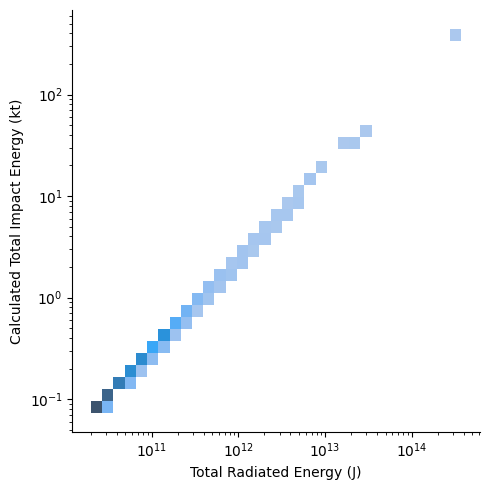

In [110]:
# visualizando a relação por meio do gráfico de dispersão
sns.displot(data=df3,x='Total Radiated Energy (J)', y='Calculated Total Impact Energy (kt)', log_scale=True)

O gráfico indica uma forte relação linear entre as variáveis Energia Irradiada e Energia de Impacto, quando  são, na verdade, já relacionadas exponencialmente. Porém, será buscado um modelo de regressão linear que permita estimar a Energia Total de Impacto a partir da Energia Irradiada:

In [136]:
res_impact = linregress(df3['Total Radiated Energy (J)'], df3['Calculated Total Impact Energy (kt)'])
print('res.slope =', res_impact.slope, '\tres.intercept =', res_impact.intercept)

res.slope = 1.1821253774296196e-12 	res.intercept = 0.33376579176366916


In [137]:
# definindo a função linear a partir dos coeficientes obtidos com a função linregress()
def impact_energy(radiated_energy):
  return radiated_energy*res_impact.slope + res_impact.intercept

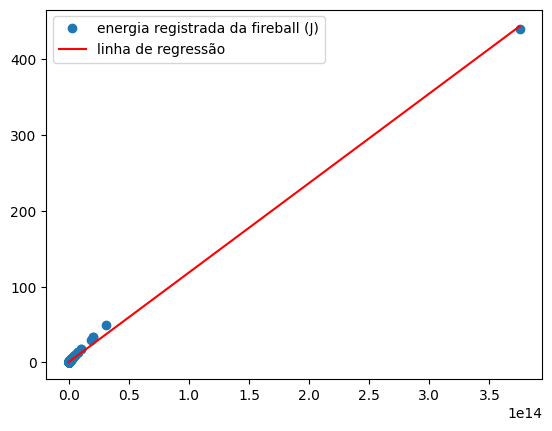

In [140]:
# plotando linha de regressão no gráfico de dispersão
x = df3['Total Radiated Energy (J)']
y = df3['Calculated Total Impact Energy (kt)']
x_test = np.linspace(df3['Total Radiated Energy (J)'].min(),df3['Total Radiated Energy (J)'].max(), 100)
plt.plot(x, y, 'o', label='energia registrada da fireball (J)')
plt.plot(x_test, impact_energy(x_test), 'r', label='linha de regressão')
plt.legend()
plt.show()

## Conclusões

### Dataset meteorite_landings

- Com relação aos dados, eles não são lineares, portanto a regressão linear não nos diz muito. O que podemos tirar da variável 'fall' é que grande parte dos meteoritos só são descobertos depois que já atingiram a terra.

#### Análise dos Fireballs

A partir do dataset sobre fireballs, pode-se observar características de hora, data, localização, velocidade, energia irradiada e energia de impacto dos meteoros. Foi descoberto que os valores de Energia Irradiada mais frequentes estavam abaixo de 0.5 joules. Foi possível observar quais foram os maiores impactos na superfície terrestre, em especial o meteoro de Chelyabinski. 
Do histograma da velocidade desses meteoros obteve-se com maior frequência as velocidades entre 10 e 20km/s. Como não foi encontrada uma correlação forte entre velocidade e energia de impacto do meteoro (em parte, porque alguns deles se desintegram antes de atingir o solo), tem-se que mesmo que penetrem a atmosfera em alta velocadade, este dado não traz informação sobre a magnitude de seu impacto na superfície. Posteriormente, foi encontrado que a força de impactoé definida exclusivamente com a energia óptica irradiada. Foi fornecido uma função linear para determinar essa relação.

-- Ajustes/Melhorias()
Define-se meteoro como o rastro luminoso de uma rocha que entra na atmosfera terrestre. Por isso, o termo da questão seria meteorito. Além disso, eventos como meteoros, fireballs e bólidos podem não resistir à entrada na armosfera e se desintegrar antes de atingir o solo. Por isso, a questão "Dentre os meteoros registrados, quais atingiram a Terra com maior energia de impacto?" foi alterada para "Entre os meteoros registrados, quais penetraram a atmosfera terrestre com maior energia de impacto?".
-Foi 

-- Trabalhos futuros
Para próximas pesquisas sobre o tema, sugere-se a análise de datasets de asteroides. A diferença entre eles e meteoritos é o diâmetro da rocha. Isso poderia ser explorado em algum dataset que trouxesse uma variável de tamanho.
Também, pode-se buscar agrupamentos dos eventos relacionados ao brilho emitido pelas rochas que entram na atmosfera terrestre. Este relatório trouxe apenas meteoros e fireballs. Outro evento a ser trazido são os bólidos, mais brilhantes que os anteriores.

-- Referências
MOURÃO, R. R. DE F. Em busca de outros mundos. Rio de Janeiro: Francisco Alves, 1982. 